# Модуль 3. Задача классификации #

Необходимо произвести предобработку данных, обучить модели на алгоритмах, рассмотренных в уроках, оценить модели с помощью рассмотренных метрик и объяснить выбор определенной метрики.

Game plan:
- Понять датасет и базовые взаимосвязи
    - Посмотреть .info() .describe()
    - Построить графики с основными данными
- Подготовить данные
- Feature Engineering
- Подготовка данных для модели
- Работа над моделью
- Финализация и результаты


### Импортируем необходимые библиотеки

In [156]:
import numpy as np
import seaborn as sns
import pandas as pd
# from clf_utils import BlackBoxMethod, fetch_dataset # если есть доступ к файлу, раскомментить
import matplotlib.pyplot as plt
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, roc_curve, auc,
                             classification_report)
from sklearn.model_selection import train_test_split

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.pipeline import make_pipeline
from sklearn.metrics import RocCurveDisplay

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

### Достаем данные:

*Информация о данных (взято из интернета)*

Data Dictionary

- survived:	Survival	0 = No, 1 = Yes 
- pclass:	Ticket class	1 = 1st, 2 = 2nd, 3 = 3rd
- sibsp:	# of siblings / spouses aboard the Titanic	
- parch:	# of parents / children aboard the Titanic	
- ticket:	Ticket number	# не выглядит как данные, которые важны для модели
- fare:	Passenger fare	# не выглядит как данные, которые важны для модели
- cabin:	Cabin number	
- embarked:	Port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton

In [157]:
import pandas as pd
data = pd.read_csv('https://lms.skillfactory.ru/asset-v1:SkillFactory+MIPTDS+SEPT22+type@asset+block@train.csv')
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [158]:
data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Сразу видим, что: 
- 38% выжило
- Возраст ранжируется от 0.4 до 80
- большинство пассажиров в 2 или 3 классе
- цена билета от 0(что странно) до 512
- нужна будет конвертация некоторых данных в цифровой формат

Мы работаем с датасетом о пассажирах Титаника. Соответсвенно, **целевой признак это Survived**. Посмотрим на данные:

In [159]:
data.Survived.value_counts()

0    549
1    342
Name: Survived, dtype: int64

На основании инфо о данных, нам менее интересны ticket и fare, т.к. это будет говорить только о статусе пассажира и его месте на корабле. Для определения этого, уже есть более точные метрики как pclass и cabin number и лучше избежать дублирования.


*upd: Возможно, эти данные могут понадобиться для определения cabin, т.к. там много пропусков*

**Посмотрим, как коррелирует возраст и пол с шансами на выживание**

<AxesSubplot:xlabel='Age', ylabel='Count'>

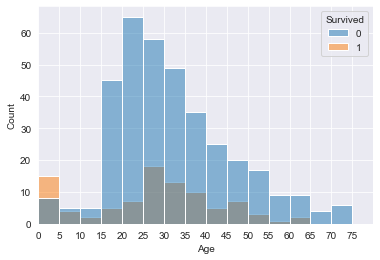

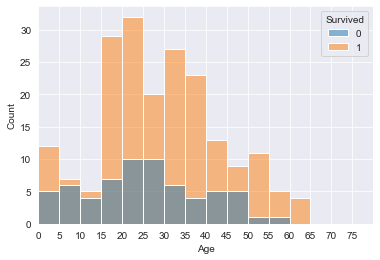

In [160]:
# Мужчины

fig, ax = plt.subplots()
ax.set_xlim(0, 80)
ax.set_xticks(range(0,80,5)) #Выше видели что max(age) = 80
sns.histplot(x=data[data.Sex == 'male'].Age.dropna(), 
             hue=data.Survived, 
             data=data[data.Sex == 'male'].Age.dropna(), 
             element='bars', 
             multiple='layer', 
             bins=range(0, 80, 5))


fig, ax = plt.subplots()
ax.set_xlim(0, 80)
ax.set_xticks(range(0,80,5)) #Выше видели что max(age) = 80
sns.histplot(x=data[data.Sex == 'female'].Age.dropna(), 
             hue=data.Survived, 
             data=data[data.Sex == 'female'].Age.dropna(), 
             element='bars', 
             multiple='layer', 
             bins=range(0, 80, 5))

Видим, что большинство женщин и детей выжили. У мужчин обратная картина.

Другие взаимосвязи:

In [161]:
pd.pivot_table(data, index = 'Survived', values = ['SibSp','Parch','Fare', 'Pclass'])

,Fare,Parch,Pclass,SibSp
Survived,,,,
0,22.117887,0.329690,2.531876,0.553734
1,48.395408,0.464912,1.950292,0.473684


<AxesSubplot:xlabel='Pclass', ylabel='Survived'>

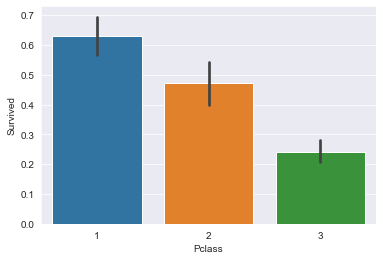

In [162]:
# Проверим взаимосвязь с классами пассажиров:
sns.barplot(x='Pclass', y='Survived', data=data)
# Предсказуемо, что пассажиры первого класса имели больше шансов на выживание.

Вопросы на данный момент:
 - Выживают богатые, что предсказуемо
 - Принцип "женщины и дети" (что про детей?)
 - Связана ли цена билета и шансы выжить? (и есть ли тут outliers как случай ДиКаприо когда бедный получил дорогой билет)

# Предобработка данных

In [163]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [164]:
total = data.isnull().sum().sort_values(ascending=False)
percent_1 = data.isnull().sum()/data.isnull().count()*100
percent_2 = (round(percent_1, 1)).sort_values(ascending=False)
missing_data = pd.concat([total, percent_2], axis=1, keys=['Total', '%'])
missing_data.head(5)

,Total,%
Cabin,687,77.1
Age,177,19.9
Embarked,2,0.2
PassengerId,0,0.0
Survived,0,0.0


Видим  что:
- почти все колонки полностью заполены,
- PassengerId не несет нужной инфо,
- Age и Embarked содержaт много пропусков и их нужно обработать. 
- Cabin по логике вещей не является показателем, который может влиять на результат (пассажиры могли быть где угодно на корабле в момент столкновения)

Итого, для обработки данных я планирую:
- удалить колонку ‘PassengerId’и "Cabin"
- заполнить Embarked модальным портом
- Для колонки age: использовать случайные числа, которые вычисляются на основе среднего значения возраста в отношении стандартного отклонения

In [165]:
data['Embarked'].describe()

count     889
unique      3
top         S
freq      644
Name: Embarked, dtype: object

In [166]:
common_value = 'S'
data['Embarked'] = data['Embarked'].fillna(common_value)

In [167]:
data = data.drop(['PassengerId'], axis=1)
data = data.drop(['Cabin'], axis=1)

In [168]:
for dataset in data:
    mean = data["Age"].mean()
    std = data["Age"].std()
    is_null = data["Age"].isnull().sum()
    # compute random numbers between the mean, std and is_null
    rand_age = np.random.randint(mean - std, mean + std, size = is_null)
    # fill NaN values in Age column with random values generated
    age_slice = data["Age"].copy()
    age_slice[np.isnan(age_slice)] = rand_age
    data["Age"] = age_slice
    data["Age"] = data["Age"].astype(int)
data["Age"].isnull().sum()

0

In [169]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       891 non-null    int32  
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Embarked  891 non-null    object 
dtypes: float64(1), int32(1), int64(4), object(4)
memory usage: 66.3+ KB


Теперь разберемся с типами данных:
- Fare  - это float64, его поменяем в int
- Sex, и Embarked поменяем в цифровое значение
- Ticket и Name нам тоже не нужен (не хватает времени вытащить титулы)

In [170]:
data['Fare'] = data['Fare'].fillna(0)
data['Fare'] = data['Fare'].astype(int)

In [171]:
genders = {"male": 0, "female": 1}
data['Sex'] = data['Sex'].map(genders)

In [172]:
ports = {"S": 0, "C": 1, "Q": 2}
data['Embarked'] = data['Embarked'].map(ports)

In [173]:
data = data.drop(['Name'], axis=1)
data = data.drop(['Ticket'], axis=1)

In [174]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   Survived  891 non-null    int64
 1   Pclass    891 non-null    int64
 2   Sex       891 non-null    int64
 3   Age       891 non-null    int32
 4   SibSp     891 non-null    int64
 5   Parch     891 non-null    int64
 6   Fare      891 non-null    int32
 7   Embarked  891 non-null    int64
dtypes: int32(2), int64(6)
memory usage: 48.9 KB


## Обучение моделей

In [175]:
# Определим исходные датасеты x и y
X = data[['Sex', 'Age', 'SibSp', 'Parch', 'Pclass', 'Fare', 'Embarked']]

y = data['Survived']

In [176]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=10)

In [177]:
def try_model(model, X_train, y_train, X_test, y_test, model_params=None):
    if model_params is None:
        model_params = dict()
    print(model.__name__)
    pipeline = make_pipeline(StandardScaler(), model(**model_params))
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    print('Accuracy:', accuracy_score(y_test, y_pred))
    print('Precision:', precision_score(y_test, y_pred))
    print('Recall:', recall_score(y_test, y_pred))
    print('F1 score:', f1_score(y_test, y_pred))

    fpr, tpr, thresholds = roc_curve(y_test, pipeline.predict_proba(X_test)[:, 1])
    plt.plot(fpr, tpr, color="darkorange", label=f"ROC curve (area = {auc(fpr, tpr):0.3f})")
    plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
    plt.legend()

    # for sklearn.__version__ of 1.0 and above
    # display = RocCurveDisplay.from_estimator(pipeline, X_test, y_test)
    # display.plot()
    # plt.show()
    return pipeline

LogisticRegression
Accuracy: 0.7982062780269058
Precision: 0.7662337662337663
Recall: 0.686046511627907
F1 score: 0.7239263803680982


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())])

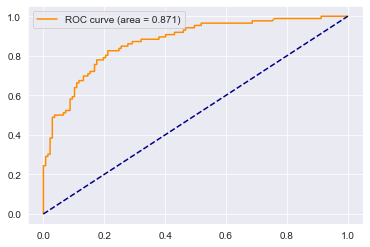

In [178]:
try_model(LogisticRegression, X_train, y_train, X_test, y_test)

GaussianNB
Accuracy: 0.8026905829596412
Precision: 0.7692307692307693
Recall: 0.6976744186046512
F1 score: 0.7317073170731708


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('gaussiannb', GaussianNB())])

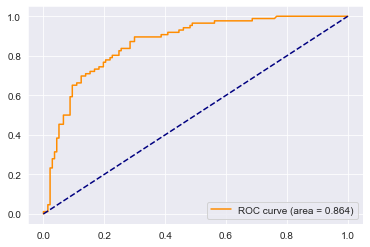

In [179]:
try_model(GaussianNB, X_train, y_train, X_test, y_test)

KNeighborsClassifier
Accuracy: 0.8161434977578476
Precision: 0.7848101265822784
Recall: 0.7209302325581395
F1 score: 0.7515151515151515


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('kneighborsclassifier', KNeighborsClassifier())])

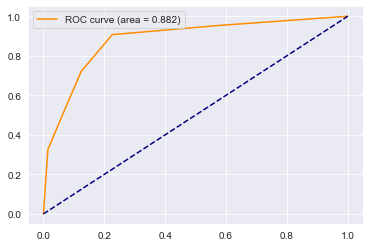

In [180]:
try_model(KNeighborsClassifier, X_train, y_train, X_test, y_test)

SVC
Accuracy: 0.8026905829596412
Precision: 0.7837837837837838
Recall: 0.6744186046511628
F1 score: 0.725


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(kernel='linear', probability=True))])

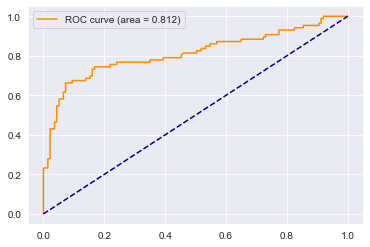

In [181]:
try_model(SVC, X_train, y_train, X_test, y_test,
          model_params=dict(
            kernel='linear',
            probability=True,
))

In [194]:
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, y_train)
y_pred = decision_tree.predict(X_test)
acc_decision_tree = round(decision_tree.score(X_train, y_train) * 100, 2)
acc_decision_tree

96.56

In [183]:
from sklearn.ensemble import RandomForestClassifier
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, y_train)
y_pred = random_forest.predict(X_test)
random_forest.score(X_train, y_train)
acc_random_forest = round(random_forest.score(X_train, y_train) * 100, 2)
acc_random_forest

96.56

## Объяснить выбор определенной метрики: 

LogisticRegression
- Accuracy: 0.7982062780269058
- Precision: 0.7662337662337663
- Recall: 0.686046511627907
- F1 score: 0.7239263803680982

GaussianNB
- Accuracy: 0.8026905829596412
- Precision: 0.7692307692307693
- Recall: 0.6976744186046512
- F1 score: 0.7317073170731708


KNeighborsClassifier
- Accuracy: 0.8161434977578476
- Precision: 0.7848101265822784
- Recall: 0.7209302325581395
- F1 score: 0.7515151515151515


SVC
- Accuracy: 0.8026905829596412
- Precision: 0.7837837837837838
- Recall: 0.6744186046511628
- F1 score: 0.725



**Итого: **

Здесь видим, что модели дали приблизительно равные результаты, чуть лучше отработали модели GaussianNB и RKNeighborsClassifier. SVC и LogisticRegression имеют низкий Recall (и поэтому F1 score).